# Choosing a Model

Model selection refers to the selection of the general function that we are fitting to the data. We need to select:
* the dependent variable(s)
* the independent variable(s)
* the functional form of relationship between them (ex. linear, polynomial etc)

For instance, we may assume that the dependent variable is a linear function of two independent variables. If model selection is not done correctly, regression assumptions may not hold and the model will not be accurate. Below we address some common model selection errors.

# Exclusion of important variables

When trying to choose our independent variables, we need to make sure we have selected the right independent variables to define the model
* If we omit a variable which is *uncorrelated* with the variables that we do include, we will simply not explain the dependent variable as well as we could. This will lead to poor predictive power in our model.
* If we omit a variable which is *correlated* with the included variables, the omission additionally affects the model. The coefficient of the included variables and the constant term in the regression will be biased by trying to compensate for the omission. This will lead us to overestimate their effect on the dependent variable. Also, estimated values of the coefficients and the estimated standard errors will be inconsistent.

In particular, we may be led to believe that two variables have a causal relationship because of their high correlation, when in fact they are both caused by a third. For instance, if two stocks both follow the market, or two quantities both tend to increase with time, they will be highly correlated. 

In [2]:
# Import the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import auquanToolbox.dataloader as dl

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\matplotlib\__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
# Pull the pricing data for our two stocks and S&P 500
start = '2013-01-01'
end = '2015-12-31'
exchange = 'nasdaq'
base = 'SPX'
m1 = 'AAPL'
m2= 'LRCX'

data = dl.load_data_nologs(exchange, [base,m1,m2], start, end)
bench = data['ADJ CLOSE'][base]
a1= data['ADJ CLOSE'][m1]
a2 = data['ADJ CLOSE'][m2]

Reading SPX
Reading AAPL
Reading LRCX


In [11]:
# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1), missing='drop').fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench), missing='drop').fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print ("R-squared values of linear regression")
print ("%s and %s: %.2f"%(m1,m2, slr12.rsquared))
print ("%s and %s: %.2f"%(m1,base, slrb1.rsquared))
print ("%s and %s: %.2f"%(m2,base, slrb2.rsquared))

R-squared values of linear regression
AAPL and LRCX: 0.90
AAPL and SPX: 0.86
LRCX and SPX: 0.91


It's hard to see consistency, or lack of it, since it is asymptotic and probabilistic. However, we can extend our sample period to see how the R-squared value changes. The correlation between the stocks and the market seems to persist, while the correlation between the two stocks drops. So we would be better off predicting the stock prices from the market price than from each other.

In [12]:
# Add additional data
start = '2013-01-01'
end = '2016-12-31'
data = dl.load_data_nologs(exchange, [base,m1,m2], start, end)
bench = data['ADJ CLOSE'][base]
a1 = data['ADJ CLOSE'][m1]
a2 = data['ADJ CLOSE'][m2]

# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print ("R-squared values of linear regression")
print ("%s and %s: %.2f"%(m1,m2, slr12.rsquared))
print ("%s and %s: %.2f"%(m1,base, slrb1.rsquared))
print ("%s and %s: %.2f"%(m2,base, slrb2.rsquared))

Reading SPX
Data ends before End Date. Filling rest of the data for SPX
Reading AAPL
Reading LRCX
R-squared values of linear regression
AAPL and LRCX: 0.73
AAPL and SPX: 0.82
LRCX and SPX: 0.88


The best way to avoid this issue is to choose the independent variables which you have reason to believe will be good predictors of the dependent variable before starting the regression analysis. **"Before" is key**: it's important not to pick variables just based on how good the regression analysis looks because that leads to overfitting.

# Inclusion of unnecessary variables

Conversely, we can have a model which includes too many independent variables
* If we include a truly unnecessary variable, we will have a lower adjusted R-squared and less precise estimates of the other regression coefficients. That is, our analysis of the model will be weakened, but the model itself will not change.

* If we include variables that are only mostly irrelevant, however, we can artificially improve the fit and the R-squared of our model by adding bits of the slightly-correlated variables to conform to the sample data. This runs the risk of overfitting, since the small adjustments we make are sample-specific. 


For example, below we run a regression with PEP price as the independent variable and PG price as the dependent variable (which may make some sense as they are in the same sector) and then run another regression with three random other stocks (MCD, CVS, DOW) added in.

Reading PEP
Reading MCD
Reading CVS
Reading DOW
Reading PG
('Using only PEP R-squared:', 0.11783118515885116)
('Using a basket of stocks R-squared:', 0.47262357809795319)


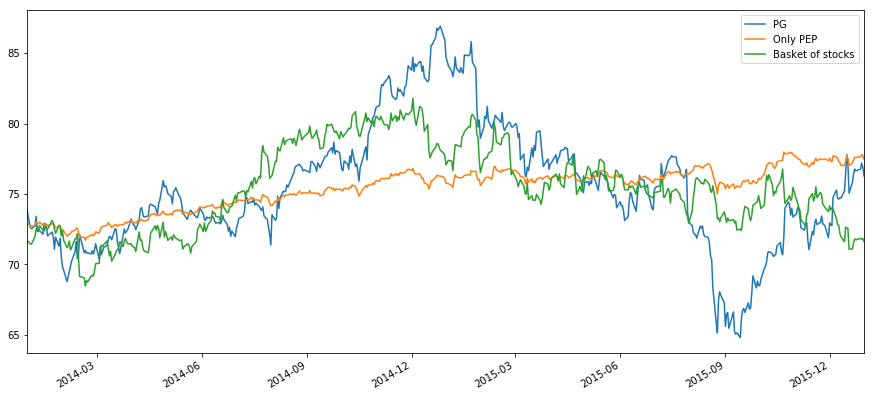

In [5]:
# Load one year's worth of pricing data for five different assets
start = '2014-01-01'
end = '2016-01-01'
m1='PEP'
m2='MCD'
m3 ='CVS'
m4='DOW'
m5='PG'
data = dl.load_data_nologs(exchange, [m1,m2,m3,m4,m5], start, end)
x1 = data['ADJ CLOSE'][m1]
x2 = data['ADJ CLOSE'][m2]
x3 = data['ADJ CLOSE'][m3]
x4 = data['ADJ CLOSE'][m4]
y = data['ADJ CLOSE'][m5]

# Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print ('Using only PEP R-squared:', slr.rsquared_adj)
print ('Using a basket of stocks R-squared:', mlr.rsquared_adj)

# Plot y along with the two different predictions
y.plot(figsize=(15,7))
slr_prediction.plot()
mlr_prediction.plot()
plt.legend(['PG', 'Only PEP', 'Basket of stocks']);
plt.show()

We are able to tune the model with more variables more precisely to the data. Note that although adjusted R-squared penalizes us for using more variables, the number of samples here is so large that the adjustment is tiny. Let's see what happens if we use the same linear models to predict the price of PG for the next six months:

Reading PEP
Reading MCD
Reading CVS
Reading DOW
Reading PG
('Using only PEP R-squared:', 0.14468460498285851)
('Using a basket of stocks R-squared:', -17.107464797750168)


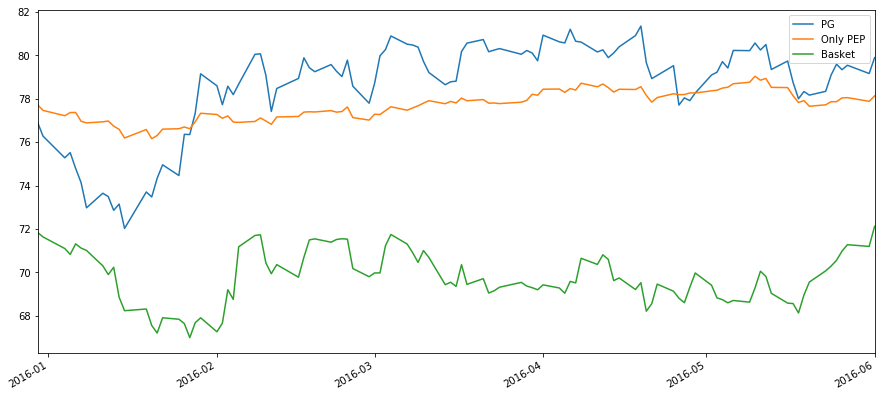

In [6]:
# Load a year and a half of pricing data
start = '2016-01-01'
end = '2016-06-01'
data = dl.load_data_nologs(exchange, [m1,m2,m3,m4,m5], start, end)
x1 = data['ADJ CLOSE'][m1]
x2 = data['ADJ CLOSE'][m2]
x3 = data['ADJ CLOSE'][m3]
x4 = data['ADJ CLOSE'][m4]
y = data['ADJ CLOSE'][m5]

# Extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared over the extended time period
adj = float(len(y) - 1)/(len(y) - 5) # Compute adjustment factor
SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print ('Using only PEP R-squared:', 1 - adj*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print ('Using a basket of stocks R-squared:', 1 - adj*SSRm/SST)

# Plot y along with the two different predictions
y.plot(figsize=(15,7))
slr_prediction2.plot()
mlr_prediction2.plot()
plt.legend(['PG', 'Only PEP', 'Basket']);
plt.show()

Both models perform rather poorly - that is, they do not hold up out of sample - but in particular the model from the multiple linear regression is now doing worse than the model from the single linear regression. Although this performance could have any number of causes, we should not be surprised since we have no reason to believe that, DOW stock has actual explanatory power in this situation.

# Errors in independent variables

When we wish to use the value of a stock $X_t$ as an independent variable, we use the stock price $S_t$ as a proxy, which is full of small, random fluctuations. $S_t = X_t + u_t$ for some error $u_t$

Now, our model is
$$ Y_t = a_0 + a_1 X_t + \epsilon_t $$

that is, that some variable is linearly related to the value of a stock. 

Since we only know the value of $S_t$, we use the model
$$ Y_t = a_0 + a_1 S_t + (-a_1u_t + \epsilon_t) $$

If $u_t$, the random error is not correlated with $X_t$, then it will be correlated with $S_t$, and so the error term $-a_1u_t + \epsilon_t$ will be correlated with our independent variable $S_t$. Consequently, the coefficients will be biased and inconsistent. In particular, $a_1$ will be biased downward.

# Incorrect functional form

After we pick the variables we wish to include, we need to specify a shape for the function. Although a regression requires that the function be linear in the coefficients, we can manipulate the variables to achieve various types of functions. For instance, the model $Y_i = b_0 + b_1 X_i^2 + \epsilon_i$ gives a quadratic relationship between $X$ and $Y$, while the log-linear model $\ln Y_i = b_0 + b_1 X_i + \epsilon_i$ gives an exponential one. Generally we select the form based on our expectation of the relationship: for example, a log-linear model is good when we expect the <i>rate of growth</i> of $Y$ to be related to $X$.

If the wrong form is selected, then we may be unable to get a good fit. In fact, the model may lead to absurd conclusions. 

We also have to be careful not to pick a functional form that overfits the data. Arbitrarily using high-degree polynomials leads to overfitting since they have more degrees of freedom. Another issue is data-mining: if we try different models until we find the one that looks best, we are overfitting to the sample at the expense of future predictivity.

# Pooling different populations

If we attempt to use one model for two populations for which separate models would be more appropriate, we get results that are misleading in one direction or the other. For instance, if we mix data about men's and women's wages, there may be too much spread to find a model that fits well, as in the artificial example below.

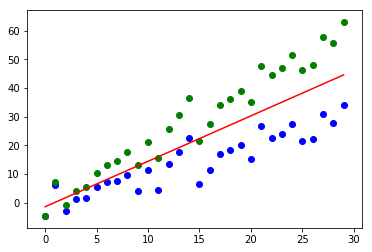

In [32]:
# Generate two artificial samples and pool them
sample1 = np.arange(30) + 4*np.random.randn(30)
sample2 = sample1 + np.arange(30)
pool = np.hstack((sample1, sample2))

# Run a regression on the pooled data, with the independent variable being the original indices
model = regression.linear_model.OLS(pool, sm.add_constant(np.hstack((np.arange(30),np.arange(30))))).fit()

# Plot the two samples along with the regression line
plt.scatter(np.arange(30), sample1, color='b')
plt.scatter(np.arange(30), sample2, color='g')
plt.plot(model.params[0] + model.params[1]*np.arange(30), color='r');
plt.show()

It's clear that two separate models for the two datasets would be more appropriate. Note that, as above, this can lead to assumption violations like heteroskedasticity and errors that are not normally distributed.

It's clear that two separate models for the two datasets would be more appropriate. Note that, as above, this can lead to assumption violations like heteroskedasticity and errors that are not normally distributed.

Conversely, we can pool sets of observations which separately demonstrate no correlation, but do appear to fit a correlation model when taken together. However, if we scale both datasets by a common factor, the fit maybe less significant. That is, the correlation between the two pools is largely due to a third variable, and thus doesn't give us any information.

In general, if we wish to compare data from different populations, we can either analyze them separately or try to adjust for the differences between them. Often we express the variables as ratios, such as scaling by company revenue or by the average wages of each population.

# Nonstationary time series

A stationary process is one whose probability distribution, in particular, its mean and variance,  does not change with time. When we apply regression models to time series, we must make the additional assumption that they are stationary. Otherwise, the t-statistics for the parameters will not be valid.

Consider a random walk - the probability of a forward step is equal to the probability of a backward step. If you start at zero, there is 50% chance you will be at +1 and 50% chance that you'll be at -1 the next instant. Therefore, the expected value is still 0.

A random walk is a process for which the next expected value is the current value.
$$E[X_t] = X_{t-1}$$
Formally, such a one-dimensional walk is described by the equation
$$ x_t = x_{t-1} + \epsilon_t $$

where the error $\epsilon_t$ is homoskedastic, has mean zero, and is not autocorrelated. For example, exchange rates are often assumed to be random walks. Random walks have variance increasing with time, and are therefore not stationary. They are subject to spurious results, and two random walks will appear highly correlated very often.

Try running the code below **several times**:

### All the walks 
First we generate 100 random walks

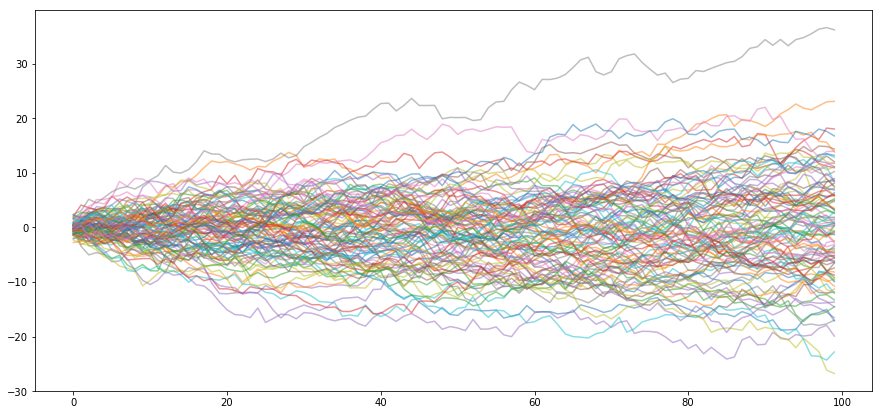

In [21]:
# Generate normally distributed errors
randos = [np.random.randn(100) for i in range(100)]
y = np.random.randn(100)
# Generate random walks
randows = [[sum(rando[:i+1]) for i in range(100)] for rando in randos]
yw = [sum(y[:i+1]) for i in range(100)]

plt.figure(figsize=(15,7))
for i in range(100):
    plt.plot(randows[i], alpha=0.5)
plt.show()    

### Just those correlated with a randomly chosen one
Now choose one walk at random, and find others that are strongly correlated (R > 0.8)

('Linearly related walks out of 100:', 14)


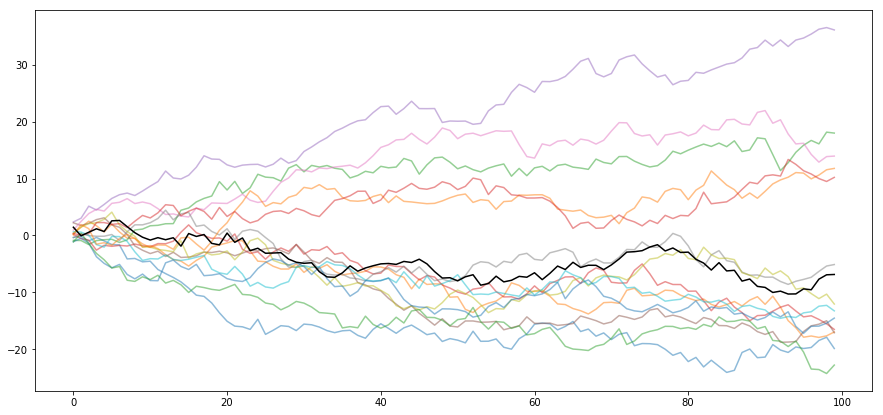

In [22]:
# Compute R-squared of linear regression for each element of randows with yw
rs = [regression.linear_model.OLS(yw, x).fit().rsquared for x in randows]
                    
# Plot and count the random walks that have R-squared with yw > .8
rcount = 0
plt.figure(figsize=(15,7))
for i in range(100):
    if rs[i] > .8:
        rcount += 1
        plt.plot(randows[i], alpha=0.5)
print ('Linearly related walks out of 100:', rcount)

# Plot yw
plt.plot(yw, color='k');
plt.show()

The reason for the two branches above is that a linear fit works well for both positively and negatively correlated variables.

The result is even more extreme if we look at the random walks with significant correlation, according to the p-values of their correlation coefficients:

('Significantly correlated walks out of 100:', 81)


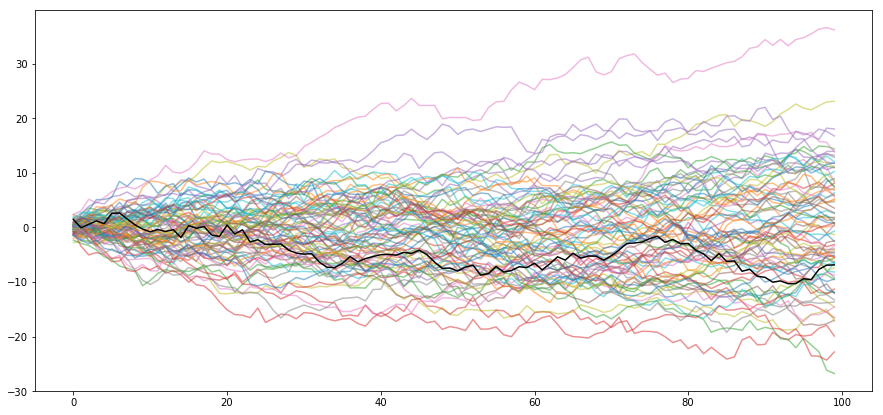

In [23]:
from scipy.stats import pearsonr

# Compute correlation coefficients (Pearson r) and record their p-values
ps = [pearsonr(yw, x)[1] for x in randows]
                    
# Plot and count the random walks that have p-value of correlation with yw < 0.05
pcount = 0
plt.figure(figsize=(15,7))
for i in range(100):
    if ps[i] < .05:
        pcount += 1
        plt.plot(randows[i], alpha=0.5)
print ('Significantly correlated walks out of 100:', pcount)

# Plot yw
plt.plot(yw, color='k');
plt.show()

Because of the high probability of spurious results, the fit statistics that we compute when regressing on random walks are invalid. Furthermore, the parameter estimates are inconsistent.

Now to test if the walk is random, we look for correlation between change in the value ($x_t - x_{t-1}$) of two series, instead of actual value ($x_t$) itself

('Linearly related walks out of 100:', 0)
('Significantly correlated walks out of 100:', 6)


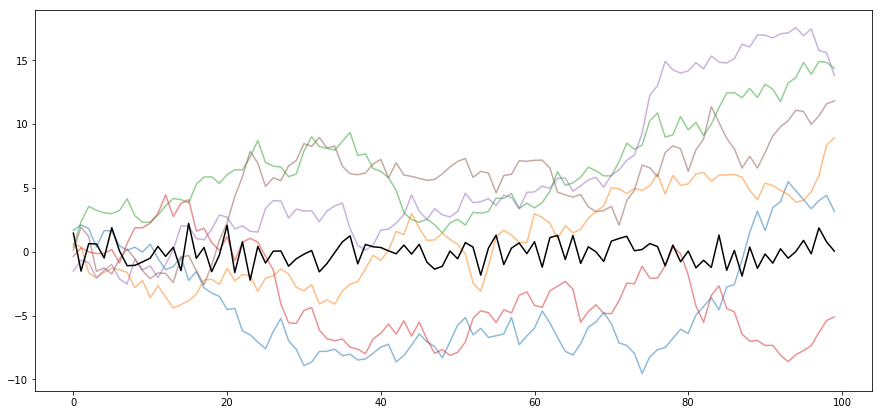

In [24]:
# Compute R-squared of linear regression for each element of randows with yw
rs = [regression.linear_model.OLS(y, x).fit().rsquared for x in randos]
                    
# Plot and count the random walks that have R-squared with yw > .8
rcount = 0
for i in range(100):
    if rs[i] > .8:
        rcount += 1
        plt.plot(randows[i], alpha=0.5)
print ('Linearly related walks out of 100:', rcount)

ps = [pearsonr(y, x)[1] for x in randos]
                    
# Plot and count the random walks that have p-value of correlation with yw < 0.05
pcount = 0
plt.figure(figsize=(15,7))
for i in range(100):
    if ps[i] < .05:
        pcount += 1
        plt.plot(randows[i], alpha=0.5)
print ('Significantly correlated walks out of 100:', pcount)

# Plot yw
plt.plot(y, color='k');
plt.show()

We can detect random walks and related time series (such as a random walk with drift) by checking for the presence of a <i>unit root</i> in the time series; that is, whether or not it appears to follow the equation $x_t = x_{t-1} + \epsilon_t$. One method is using the Dickey-Fuller test:

In [37]:
from statsmodels.tsa.stattools import adfuller

# Compute the p-value of the Dickey-Fuller statistic to test the null hypothesis that yw has a unit root
print (adfuller(yw)[1])

0.459666301663


Therefore we cannot reject the hypothesis that `yw` has a unit root (as we know it does, by construction).

If we know that a time series has a unit root and we would like to analyze it anyway, we can model instead the first differenced series $y_t = x_t - x_{t-1}$ if that is stationary, and use it to predict future values of $x$. We can also use regression if both the dependent and independent variables are time series with unit roots and the two are cointegrated.